This notebook serializes the method for data preprocessing, training and evaluation of the models. The code below this block Defines the Data preprocessing procedure, the training procedure and evaluation code. All the models utilize the same functions for obtaining the output. Please run all the blocks to successfully traing and evaluate the models. Additionally, for this Model we r

Data Preprocessing:
-Changing the dataset to Tensor
-Normalizing the dataset
-Importing the dataset using CIFAR10 from torch
-Using Subset from torch to make subset of the data for 500 images per class for training and 100 for testing
-Making dataloaders to set the batch size for training and testing

Training:
-Training all the models for 100 epochs
-Cross Entropy Loss function for all models
-Optmizer is SGD with learning rate 0.01 and momentum of 0.9

Evaluation:
-We use sickit learn for calculating the metrics
-The function evaluate model prints the metrics for all the models


In [ ]:
#libraries imported
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
from sklearn.decomposition import PCA
from torchvision.models import resnet18
import time


#Note that the model is trained on cpu
# Define transformations for resizing and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet-18
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the full CIFAR-10 dataset
train_dataset_full = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset_full = CIFAR10(root='./data', train=False, transform=transform, download=True)

# Function to filter the dataset
def filter_dataset(dataset, num_samples_per_class):
    class_counts = {i: 0 for i in range(10)}  # Track counts for each class (0 to 9)/10 classes
    indices = []  # Store selected indices

    for idx, (_, label) in enumerate(dataset):
        if class_counts[label] < num_samples_per_class:
            indices.append(idx)
            class_counts[label] += 1
        # Stop early if all classes have enough samples
        if all(count >= num_samples_per_class for count in class_counts.values()):
            break

    return Subset(dataset, indices)

# Filter datasets
train_dataset = filter_dataset(train_dataset_full, num_samples_per_class=500)
test_dataset = filter_dataset(test_dataset_full, num_samples_per_class=100)
print(train_dataset_full.classes)
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Load pre-trained ResNet-18 and remove the last layer
model = resnet18(pretrained=True)

feature_extractor = nn.Sequential(*list(model.children())[:-1])  # Remove the last fully connected layer
feature_extractor.eval()  # Set to evaluation mode

# Extract features from the dataset
def extract_features(loader, model):
    features, labels = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs).squeeze()
            features.append(outputs)
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)

# Extract features for training and testing
train_features, train_labels = extract_features(train_loader, feature_extractor)
test_features, test_labels = extract_features(test_loader, feature_extractor)

c:\Users\umara\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\umara\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Transform the features to vectors using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(train_features.numpy())
test_features_pca = pca.transform(test_features.numpy())


The Code block below is for functions: training and evaluation. Train_model performs the training of all the models, it takes parameters as model, train features, train labels, epochs. Although train features and labels don't change, this was done to experiment with the dataset. The evaluation function is also defined in this cell. These are the functions used by the models

In [ ]:


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
criterion = nn.CrossEntropyLoss()


# Training loop
def train_model(model, train_features, train_labels, epochs=100):
    #setting the optimizer, note that that mlp_model is set in the Model definitions when it is called for training
    #It is the same as model taken from the parameter
    optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9)
    model.train()
    for epoch in range(epochs):

        optimizer.zero_grad()
        outputs = model(torch.tensor(train_features, dtype=torch.float32))

        loss = criterion(outputs, torch.tensor(train_labels, dtype=torch.long))
        loss.backward()

        optimizer.step()
        #un-comment the code below to check loss at epochs
        #print(f'Epoch {epoch+1}, Loss: {loss.item()}')



# Evaluation
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        
        predictions = model(torch.tensor(test_features, dtype=torch.float32))
        
        predicted_labels = predictions.argmax(dim=1).numpy()
        
        true_labels = test_labels.numpy()

        test_loss = criterion(predictions, test_labels.clone().detach().long()).item()
        
    # Metrics
    acc = accuracy_score(true_labels, predicted_labels)
    
    report = classification_report(true_labels, predicted_labels, target_names=train_dataset_full.classes)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))

    #Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset_full.classes, yticklabels=train_dataset_full.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'Accuracy: {acc}')
    print(f'Test Loss: {test_loss}')
    print('Classification Report:\n', report)


MLP Base Case

C:\Users\umara\AppData\Local\Temp\ipykernel_36308\1091908344.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_labels, dtype=torch.long))


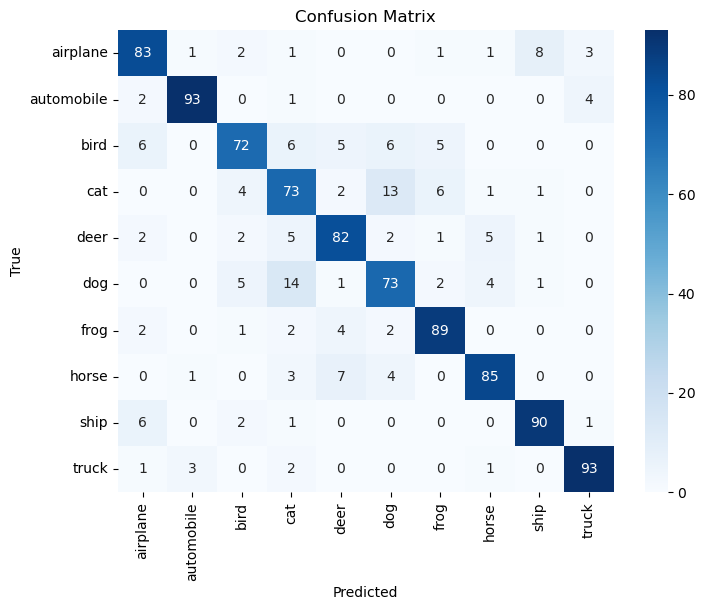

Accuracy: 0.833
Test Loss: 0.47554782032966614
Classification Report:
               precision    recall  f1-score   support

    airplane       0.81      0.83      0.82       100
  automobile       0.95      0.93      0.94       100
        bird       0.82      0.72      0.77       100
         cat       0.68      0.73      0.70       100
        deer       0.81      0.82      0.82       100
         dog       0.73      0.73      0.73       100
        frog       0.86      0.89      0.87       100
       horse       0.88      0.85      0.86       100
        ship       0.89      0.90      0.90       100
       truck       0.92      0.93      0.93       100

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



In [ ]:

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(50, 512),       # Input layer
            nn.ReLU(),
            nn.Linear(512, 512),      # Hidden layer with batch normalization
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)        # Output layer
        )

    def forward(self, x):
        return self.layers(x)
mlp_model = MLP()
start_time = time.time()
train_model(mlp_model, train_features_pca, train_labels, epochs=100)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")
#This code below is to save the model
#torch.save(model.state_dict(), r'C:\Users\umara\OneDrive\Desktop\University\COMP 472\Project\Results\Models\MLP.pth')

evaluate_model(mlp_model, test_features_pca, test_labels)


MLP with extra hidden layers

C:\Users\umara\AppData\Local\Temp\ipykernel_36308\1091908344.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_labels, dtype=torch.long))


Training time: 8.407609701156616 seconds


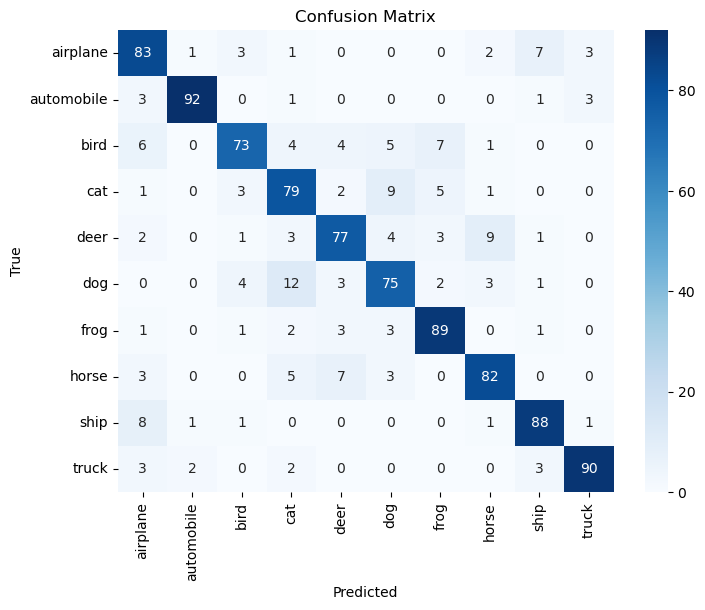

Accuracy: 0.828
Test Loss: 0.5093013048171997
Classification Report:
               precision    recall  f1-score   support

    airplane       0.75      0.83      0.79       100
  automobile       0.96      0.92      0.94       100
        bird       0.85      0.73      0.78       100
         cat       0.72      0.79      0.76       100
        deer       0.80      0.77      0.79       100
         dog       0.76      0.75      0.75       100
        frog       0.84      0.89      0.86       100
       horse       0.83      0.82      0.82       100
        ship       0.86      0.88      0.87       100
       truck       0.93      0.90      0.91       100

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



In [ ]:
class MLP_V1(nn.Module):
    def __init__(self):
        super(MLP_V1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(50, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),  # Additional hidden layer
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),  # Additional hidden layer
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)    # Output layer
        )

    def forward(self, x):
        return self.layers(x)
    
mlp_model = MLP_V1()

start_time = time.time()
train_model(mlp_model, train_features_pca, train_labels, epochs=100)
end_time = time.time()

#This code below is to save the model
#torch.save(model.state_dict(), r'C:\Users\umara\OneDrive\Desktop\University\COMP 472\Project\Results\Models\MLP_V1.pth')

print(f"Training time: {end_time - start_time} seconds")

evaluate_model(mlp_model, test_features_pca, test_labels)


MLP with less layers than the base case

C:\Users\umara\AppData\Local\Temp\ipykernel_36308\1091908344.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_labels, dtype=torch.long))


Training time: 0.9547829627990723 seconds


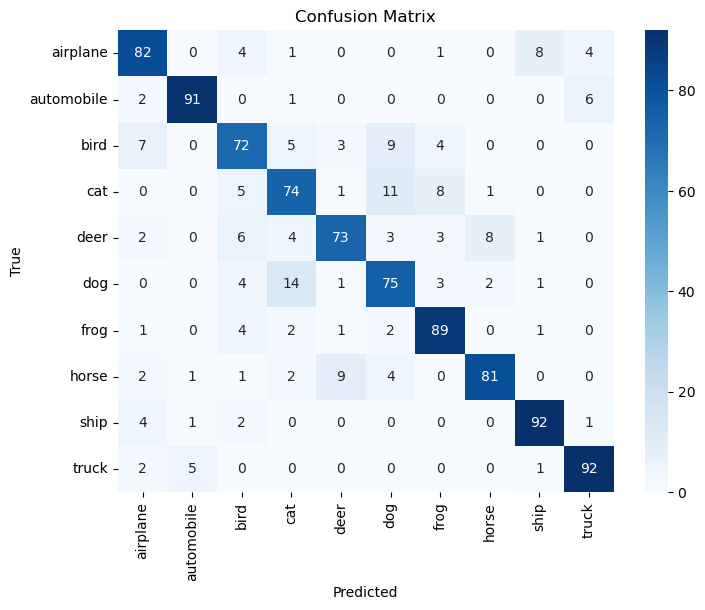

Accuracy: 0.821
Test Loss: 0.514582097530365
Classification Report:
               precision    recall  f1-score   support

    airplane       0.80      0.82      0.81       100
  automobile       0.93      0.91      0.92       100
        bird       0.73      0.72      0.73       100
         cat       0.72      0.74      0.73       100
        deer       0.83      0.73      0.78       100
         dog       0.72      0.75      0.74       100
        frog       0.82      0.89      0.86       100
       horse       0.88      0.81      0.84       100
        ship       0.88      0.92      0.90       100
       truck       0.89      0.92      0.91       100

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



In [ ]:
class MLP_V2(nn.Module):
    def __init__(self):
        super(MLP_V2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(50, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.layers(x)
mlp_model = MLP_V2()
start_time = time.time()
train_model(mlp_model, train_features_pca, train_labels, epochs=100)
end_time = time.time()

#This code below is to save the model
#torch.save(model.state_dict(), r'C:\Users\umara\OneDrive\Desktop\University\COMP 472\Project\Results\Models\MLP_V2.pth')

print(f"Training time: {end_time - start_time} seconds")
evaluate_model(mlp_model, test_features_pca, test_labels)

MLP with Less Neurons in the layer(weights)

C:\Users\umara\AppData\Local\Temp\ipykernel_36308\1091908344.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_labels, dtype=torch.long))


Training time: 1.3891105651855469 seconds


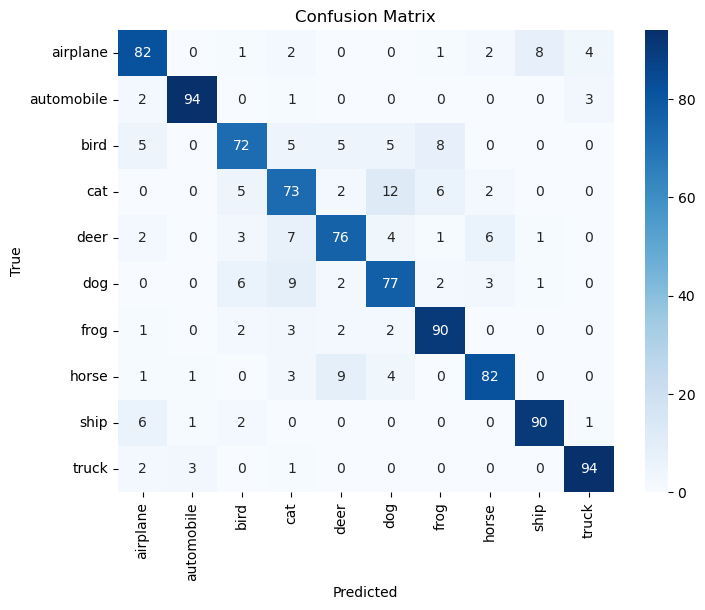

Accuracy: 0.83
Test Loss: 0.515907883644104
Classification Report:
               precision    recall  f1-score   support

    airplane       0.81      0.82      0.82       100
  automobile       0.95      0.94      0.94       100
        bird       0.79      0.72      0.75       100
         cat       0.70      0.73      0.72       100
        deer       0.79      0.76      0.78       100
         dog       0.74      0.77      0.75       100
        frog       0.83      0.90      0.87       100
       horse       0.86      0.82      0.84       100
        ship       0.90      0.90      0.90       100
       truck       0.92      0.94      0.93       100

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



In [ ]:
class MLP_V3(nn.Module):
    def __init__(self):
        super(MLP_V3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(50, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.layers(x)
mlp_model = MLP_V3()
start_time = time.time()
train_model(mlp_model, train_features_pca, train_labels, epochs=100)
end_time = time.time()

#This code below is to save the model
#torch.save(model.state_dict(), r'C:\Users\umara\OneDrive\Desktop\University\COMP 472\Project\Results\Models\MLP_V3.pth')

print(f"Training time: {end_time - start_time} seconds")
evaluate_model(mlp_model, test_features_pca, test_labels)

MLP with more Neurons in the layers(weights)

C:\Users\umara\AppData\Local\Temp\ipykernel_36308\1091908344.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_labels, dtype=torch.long))


Training time: 10.117470502853394 seconds


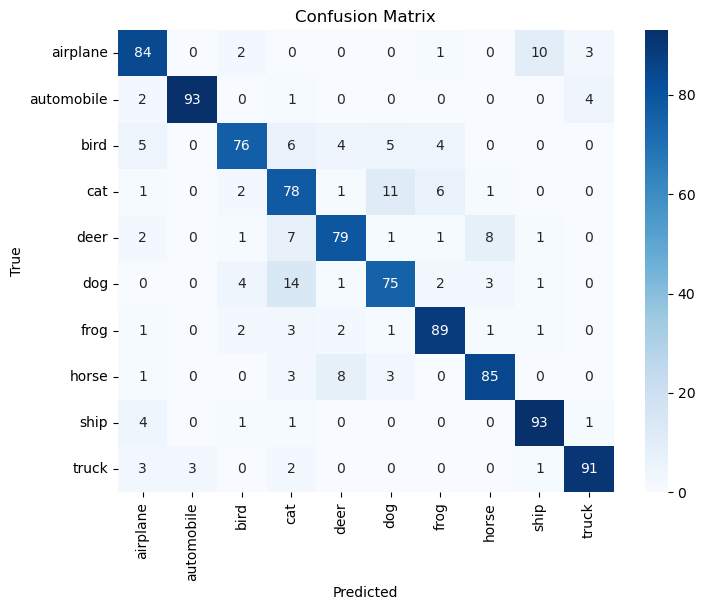

Accuracy: 0.843
Test Loss: 0.4715401828289032
Classification Report:
               precision    recall  f1-score   support

    airplane       0.82      0.84      0.83       100
  automobile       0.97      0.93      0.95       100
        bird       0.86      0.76      0.81       100
         cat       0.68      0.78      0.73       100
        deer       0.83      0.79      0.81       100
         dog       0.78      0.75      0.77       100
        frog       0.86      0.89      0.88       100
       horse       0.87      0.85      0.86       100
        ship       0.87      0.93      0.90       100
       truck       0.92      0.91      0.91       100

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000



In [ ]:
class MLP_V4(nn.Module):
    def __init__(self):
        super(MLP_V4, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(50, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        return self.layers(x)
mlp_model = MLP_V4()
start_time = time.time()
train_model(mlp_model, train_features_pca, train_labels, epochs=100)
end_time = time.time()

#This code below is to save the model
#torch.save(model.state_dict(), r'C:\Users\umara\OneDrive\Desktop\University\COMP 472\Project\Results\Models\MLP_V4.pth')

print(f"Training time: {end_time - start_time} seconds")
evaluate_model(mlp_model, test_features_pca, test_labels)